# **Import Libraries**

In [1]:
!pip install nflreadpy

In [2]:
import pandas as pd
import numpy as np
import nflreadpy as nfl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit

# **Understanding how Expected Points changed based on Field Position**

In [3]:
first_down_list = []
for season in range(1999, 2025):
    # retrieve the season's play by play data
    season_data = nfl.load_pbp(season).to_pandas()
    first_down_data = season_data[
        (season_data['down'] == 1) &
        (season_data['season_type'] == "REG")
    ]
    # add punt data to the list
    first_down_list.append(first_down_data)

# combine all seasons of punt data into one dataframe
first_down_df = pd.concat(first_down_list)

yards_ep = []

# for yard line in first_down_df
for yard_line in first_down_df['yardline_100'].unique():
    ep = first_down_df[first_down_df['yardline_100'] == yard_line]['ep'].mean()
    yards_ep.append([yard_line, ep])

yards_ep_df = pd.DataFrame(yards_ep, columns=['yardline', 'expected_points'])
yards_ep_df.sort_values(by='yardline', inplace=True)
yards_ep_df

,yardline,expected_points
28,1.0,6.232887
76,2.0,6.081488
14,3.0,5.914250
44,4.0,5.729555
61,5.0,5.566370
...,...,...
92,95.0,-0.343059
31,96.0,-0.408160
88,97.0,-0.414607
32,98.0,-0.530430


In [4]:
#yards_ep_df['MULTIPLIER'] = yards_ep_df['expected_points'] / yards_ep_df.loc[yards_ep_df['yardline'] == 90.0, 'expected_points'].iloc[0]
yards_ep_df

,yardline,expected_points
28,1.0,6.232887
76,2.0,6.081488
14,3.0,5.914250
44,4.0,5.729555
61,5.0,5.566370
...,...,...
92,95.0,-0.343059
31,96.0,-0.408160
88,97.0,-0.414607
32,98.0,-0.530430


a=5.5135, b=-0.0621


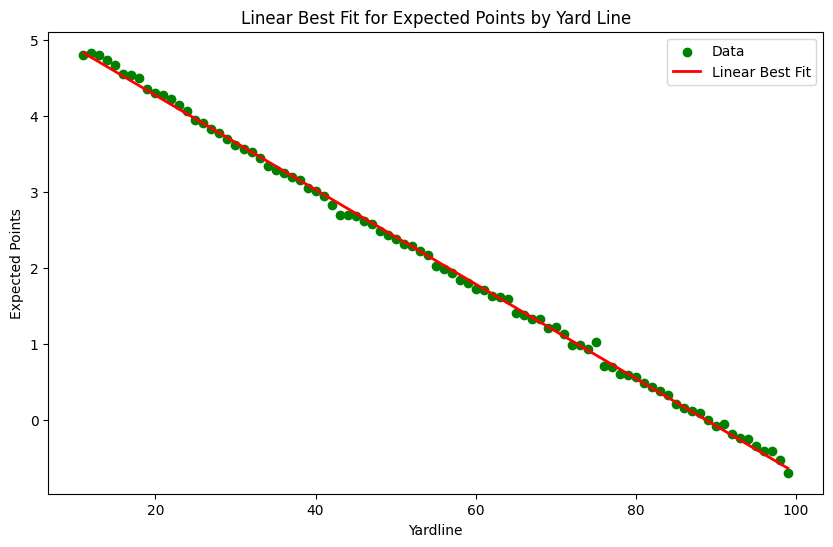

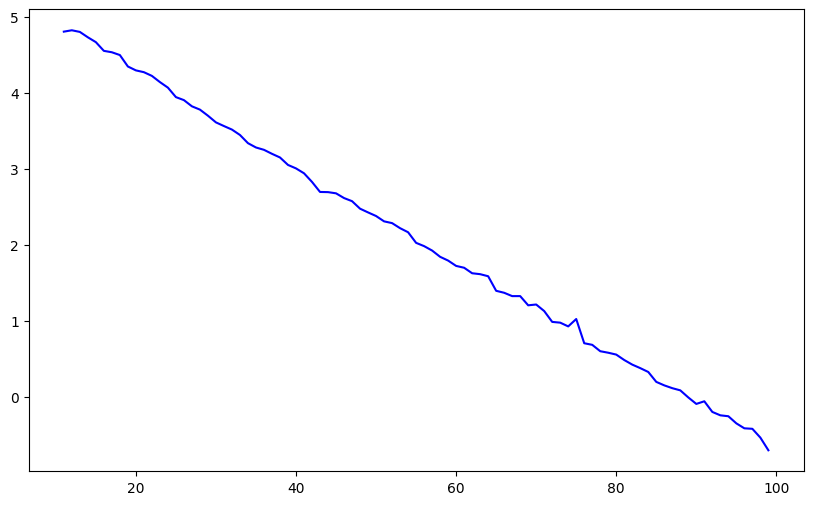

In [5]:
def line_function(x, a, b):
    return a + b * x

# Filter data for yardline > 31
mask = yards_ep_df['yardline'] > 10
x_data = yards_ep_df.loc[mask, 'yardline'].reset_index(drop=True)
y_data = yards_ep_df.loc[mask, 'expected_points'].reset_index(drop=True)

# Initial guess: [rate, amplitude, asymptote]
initial_guess = [5.5, -0.1]

# Fit the model
params, cov = curve_fit(
    line_function,
    x_data,
    y_data,
    p0=initial_guess,
    maxfev=10000
)

a_fit, b_fit = params
print(f"a={a_fit:.4f}, b={b_fit:.4f}")

# Generate smooth curve for plotting
x_fit = np.linspace(x_data.min(), x_data.max(), 300)
y_fit = line_function(x_fit, *params)

# Plot fitted curve
plt.figure(figsize=(10, 6))
plt.scatter(x_data, y_data, color='green', label='Data')
plt.plot(x_fit, y_fit, color='red', linewidth=2, label='Linear Best Fit')
plt.xlabel('Yardline')
plt.ylabel('Expected Points')
plt.title('Linear Best Fit for Expected Points by Yard Line')
plt.legend()
plt.show()

# graph yardline vs expected_points, only yardline > 60
plt.figure(figsize=(10, 6))
mask = yards_ep_df[yards_ep_df['yardline'] > 10]
plt.plot(mask['yardline'], mask['expected_points'], label='Expected Points', color='blue')

### **Retrieve all punt data**

In [6]:
# retrieve all available schedules
#sched = nfl.load_schedules()

# retrieve all play by play data
punt_pbp_list = []
# load all seasons into the play by play data
for season in range(1999, 2025):
    # retrieve the season's play by play data
    season_data = nfl.load_pbp(season).to_pandas()
    # only retrieve regular season punts (not blocked)
    punt_season_data = season_data[
        (season_data['play_type'] == "punt") &
        (season_data['punt_blocked'] == 0) &
        (season_data['season_type'] == "REG")
    ]
    #print(season)
    # add punt data to the list
    punt_pbp_list.append(punt_season_data)

# combine all seasons of punt data into one dataframe
punt_pbp = pd.concat(punt_pbp_list)

#punt_pbp.head()

In [7]:
# percentage of punts that are "long punts" (60 yards away from the endzone)
len(punt_pbp[punt_pbp['yardline_100'] > 60]) / len(punt_pbp)

0.6137968229064522

# **Create Punter Rating**

**Punter Rating** is the combination of two parameters, the Precision Punting Parameter for punts where positioning is important and the Long Punting Parameter for when the punter needs to flip the field.

### **Punter Rating** = 100 * (0.4 * PPP (Yard Line 60) + 0.6 * LPP (Yard Line > 61))

*   **Precision Punting Parameter (PPP)** (for Punts 60 yards away or less from the endzone)

PPP = (# of Punts Fair Caught, Downed, or No Return Inside 20 + 0.5 *  # of Punts Inside 5 - # of 10+ Yard Returns) / # of Punts  60 Yard Line

*   **Long Punting Parameter (LPP)** (for Punts greater than 60 yards from the endzone)

LPP = (# of 48+ Yard Punts + # of 41+ Net Yard Punts+0.2*(60+ Yard Punts)) / # of Punts >= 60 Yard Line

In [8]:
# Calculate the final position of the punt
punt_pbp['punt_finish'] = punt_pbp['yardline_100'] - punt_pbp['kick_distance'] + 20 * punt_pbp['punt_in_endzone'] - punt_pbp['return_yards']
punt_pbp['punt_land'] = punt_pbp['yardline_100'] - punt_pbp['kick_distance']
# Add a binary indicator whether punt is inside the 5 yard line
punt_pbp['punt_inside_five'] = np.where(punt_pbp['punt_finish'] <= 5, 1, 0)

def precision_punting_parameter(player_name):
    precision_punts = punt_pbp[(punt_pbp['yardline_100'] <= 60) & (punt_pbp['punter_player_name'] == player_name)]

    downed_punts_within_20_count = 0
    out_of_bounds_punts_within_20_count = 0
    no_return_punt_within_20_count = 0

    for index, punt in precision_punts[precision_punts['punt_land'] < 20].iterrows():
        if punt['punt_downed'] == 1:
            downed_punts_within_20_count += 1
        elif punt['punt_out_of_bounds'] == 1:
            out_of_bounds_punts_within_20_count += 1
        elif punt['return_yards'] == 0 and punt['punt_downed'] == 0 and punt['punt_out_of_bounds'] == 0:
            no_return_punt_within_20_count += 1

    # find number of punts finishing inside 5 yard line
    inside_5_yard_line_punt = precision_punts[precision_punts['punt_land'] <= 5]
    touchback_punt = precision_punts[precision_punts['punt_in_endzone'] == 1]
    long_returns = precision_punts[precision_punts['return_yards'] >= 10]

    num_downed_punts = downed_punts_within_20_count
    num_out_of_bounds_punts = out_of_bounds_punts_within_20_count
    num_no_return_punts = no_return_punt_within_20_count
    num_inside_5_yard_line = len(inside_5_yard_line_punt)
    num_touchback_punts = len(touchback_punt)
    num_long_returns = len(long_returns)

    if len(precision_punts) == 0:
        return 0, 0
    else:
        precision_punting_parameter = (num_downed_punts + num_out_of_bounds_punts + num_no_return_punts + 0.5 * num_inside_5_yard_line - num_long_returns) / len(precision_punts)
        return precision_punting_parameter, len(precision_punts)

In [9]:
def long_punting_parameter(player_name):
    long_punts = punt_pbp[(punt_pbp['yardline_100'] > 60) & (punt_pbp['punter_player_name'] == player_name)]
    num_punts = len(long_punts)
    overexpected_punt_count = 0
    overexpected_net_count = 0
    # for each punt in long punts
    for index, punt in long_punts.iterrows():
      if punt['kick_distance'] > 47.5:
        overexpected_punt_count += 1
      elif (punt['kick_distance'] - punt['return_yards']) > 41.5:
        overexpected_net_count += 1

    num_massive_kicks = len(long_punts[long_punts['kick_distance'] > 59.5])

    total_yards = long_punts['kick_distance'].sum()

    #overexpected_net_count = 0

    if num_punts == 0:
        return 0, 0
    else:
        long_punting_parameter = (overexpected_punt_count + overexpected_net_count + 0.2 * num_massive_kicks) / (num_punts)
    return long_punting_parameter, num_punts

In [10]:
punter_parameter_list = []

# add punt land to punt_pbp
punt_pbp['punt_land'] = punt_pbp['yardline_100'] - punt_pbp['kick_distance'] + 20 * punt_pbp['punt_in_endzone'] - punt_pbp['return_yards']

for player in punt_pbp['punter_player_name'].unique():
    punter_rating = 100 * (0.4 * precision_punting_parameter(player)[0] + 0.6 * long_punting_parameter(player)[0])
    punter_parameter_list.append([player, precision_punting_parameter(player)[0], precision_punting_parameter(player)[1], long_punting_parameter(player)[0], long_punting_parameter(player)[1], punter_rating])

ppp_punter_df = pd.DataFrame(punter_parameter_list, columns=['player_name', 'precision_punting_parameter', 'number_of_precision_punts', 'long_punting_parameter', 'number_of_long_punts', 'punter_rating'])
ppp_punter_df['total_punts'] = ppp_punter_df['number_of_precision_punts'] + ppp_punter_df['number_of_long_punts']
# sort by highest ppp
ppp_punter_df = ppp_punter_df.sort_values(by='punter_rating', ascending=False).reset_index(drop=True)

# round parameter and rating values to

# only include where more than 250 punts
#ppp_punter_df = ppp_punter_df[ppp_punter_df['total_punts'] > 250].reset_index(drop=True)
ppp_punter_df

# only show columns for player_name and punter_rating
#ppp_punter_df[['player_name', 'punter_rating']]

,player_name,precision_punting_parameter,number_of_precision_punts,long_punting_parameter,number_of_long_punts,punter_rating,total_punts
0,P.Dawson,1.166667,9,1.000000,1,106.666667,10
1,R.Stonehouse,0.885246,61,0.975484,155,93.938868,216
2,C.Nizialek,1.214286,7,0.745455,11,93.298701,18
3,A.Cole,0.911565,147,0.947137,227,93.290779,374
4,H.Niswander,1.062500,8,0.833333,18,92.500000,26
...,...,...,...,...,...,...,...
258,S.Janikowski,0.000000,0,0.000000,1,0.000000,1
259,R.Flinn,-0.166667,3,0.000000,3,-6.666667,6
260,G.Joseph,-0.500000,1,0.000000,0,-20.000000,1
261,T.Dorsch,-0.500000,1,0.000000,4,-20.000000,5


# **How Punter Rating relates to Team Outcome**

In [11]:
import pandas as pd
import polars as pl

# Load 2024 season data
season = 2024
punt_pbp_2024_pl = nfl.load_pbp(season)
schedules_pl = nfl.load_schedules(season)

# Filter for punt plays only (using Polars syntax)
punt_pbp_2024_pl = punt_pbp_2024_pl.filter(pl.col('play_type') == 'punt')
pbp_2024_pl = nfl.load_pbp(season)

# Convert to pandas for easier manipulation
pbp_2024 = pbp_2024_pl.to_pandas()
punt_pbp_2024 = punt_pbp_2024_pl.to_pandas()
schedules = schedules_pl.to_pandas()

# Get unique teams
teams = punt_pbp_2024['posteam'].dropna().unique()

# Initialize list to store team statistics
team_stats_list = []

for team in teams:
    team_punts = punt_pbp_2024[punt_pbp_2024['posteam'] == team]

    # Calculate safety percentage
    total_punts = len(team_punts)
    total_safeties = len(pbp_2024[(pbp_2024['defteam'] == team) & (pbp_2024['safety'] == 1)])

    # Calculate opposing team's average points scored
    opponent_scores = []
    for idx, row in team_punts.iterrows():
        defteam = row['defteam']
        game_id = row['game_id']

        # Get all plays from that game for the opposing team
        game_plays = punt_pbp_2024[(punt_pbp_2024['game_id'] == game_id) &
                              (punt_pbp_2024['posteam'] == defteam)]
        if len(game_plays) > 0:
            opponent_scores.append(game_plays['total_home_score'].iloc[-1] if defteam == game_plays['home_team'].iloc[0]
                                  else game_plays['total_away_score'].iloc[-1])

    avg_opponent_points = sum(opponent_scores) / len(opponent_scores) if opponent_scores else 0

    # Calculate winning percentage
    team_games = schedules[(schedules['home_team'] == team) | (schedules['away_team'] == team)]
    wins = 0
    total_games = 0

    for idx, game in team_games.iterrows():
        if pd.notna(game['result']):
            total_games += 1
            if game['home_team'] == team:
                if game['result'] > 0:
                    wins += 1
            else:
                if game['result'] < 0:
                    wins += 1

    win_pct = (wins / total_games * 100) if total_games > 0 else 0

    # Find primary punter (most punts for the team)
    team_punters = team_punts['punter_player_name'].value_counts()
    primary_punter = team_punters.index[0] if len(team_punters) > 0 else 'Unknown'

    # Calculate punter rating using your existing functions
    if primary_punter != 'Unknown':
        try:
            punter_rating = 100 * (0.4 * precision_punting_parameter(primary_punter)[0] +
                                  0.6 * long_punting_parameter(primary_punter)[0])
        except:
            punter_rating = None
    else:
        punter_rating = None

    team_stats_list.append({
        'Team': team,
        'Total_Punts': total_punts,
        'Total Safeties': total_safeties,
        'Avg_Opponent_Points': avg_opponent_points,
        'Win_Percentage': win_pct,
        'Primary_Punter': primary_punter,
        'Punter_Rating': punter_rating
    })

# Create DataFrame
team_stats_df = pd.DataFrame(team_stats_list)

# Sort by win percentage descending
team_stats_df = team_stats_df.sort_values('Win_Percentage', ascending=False)

# Display results
print("\n2024 NFL Team Punting Statistics\n")
print(team_stats_df.to_string(index=False))

# Optional: Save to CSV
team_stats_df.to_csv('2024_team_punt_stats.csv', index=False)


2024 NFL Team Punting Statistics

Team  Total_Punts  Total Safeties  Avg_Opponent_Points  Win_Percentage Primary_Punter  Punter_Rating
 PHI           68               0             9.761194       85.714286         B.Mann      80.100294
  KC           72               0            13.833333       85.000000       M.Araiza      89.616725
 DET           46               0            17.021739       83.333333          J.Fox      89.010166
 MIN           60               0            11.683333       77.777778       R.Wright      83.887430
 BUF           61               1            17.051724       75.000000       S.Martin      84.453645
 WAS           52               0            13.461538       70.000000          T.Way      87.172356
 BAL           59               0            12.525424       68.421053        J.Stout      89.003077
  GB           58               0            14.465517       61.111111       D.Whelan      79.333333
 LAC           77               0            11.405405  

In [12]:
# replace punter rating in team_stats_df using Primary_Punter = ppp_punter_df['player_name']
for index, row in team_stats_df.iterrows():
    if row['Primary_Punter'] in ppp_punter_df['player_name'].values:
        team_stats_df.loc[index, 'Punter_Rating'] = ppp_punter_df.loc[ppp_punter_df['player_name'] == row['Primary_Punter'], 'punter_rating'].values[0]
    else:
        team_stats_df.loc[index, 'Punter_Rating'] = None

team_stats_df

,Team,Total_Punts,Total Safeties,Avg_Opponent_Points,Win_Percentage,Primary_Punter,Punter_Rating
11,PHI,68,0,9.761194,85.714286,B.Mann,80.100294
3,KC,72,0,13.833333,85.000000,M.Araiza,89.616725
17,DET,46,0,17.021739,83.333333,J.Fox,89.010166
21,MIN,60,0,11.683333,77.777778,R.Wright,83.887430
1,BUF,61,1,17.051724,75.000000,S.Martin,84.453645
30,WAS,52,0,13.461538,70.000000,T.Way,87.172356
2,BAL,59,0,12.525424,68.421053,J.Stout,89.003077
10,GB,58,0,14.465517,61.111111,D.Whelan,79.333333
18,LAC,77,0,11.405405,61.111111,J.Scott,78.774300
8,SEA,76,1,17.381579,58.823529,M.Dickson,90.132875


Text(0, 0.5, 'Average Opponent Points')

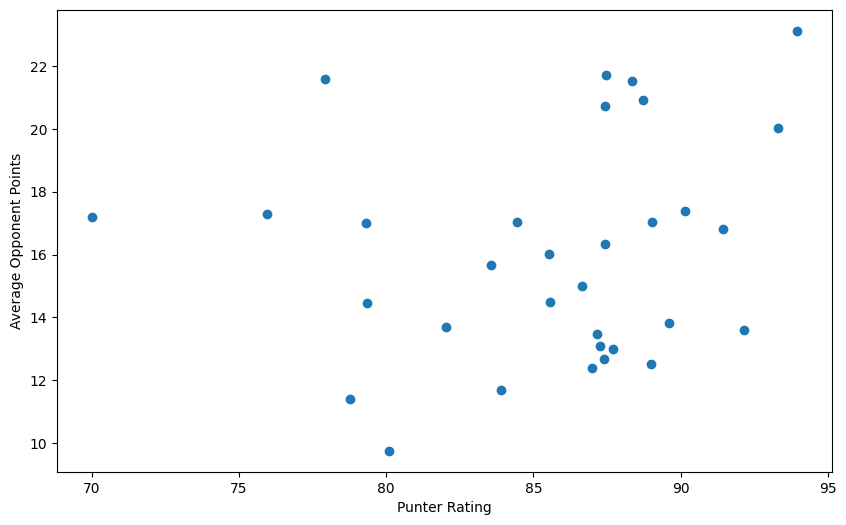

In [13]:
# Graph Opponent Punter Rating vs Avg Points
plt.figure(figsize=(10, 6))
plt.scatter(team_stats_df['Punter_Rating'], team_stats_df['Avg_Opponent_Points'],)
plt.xlabel('Punter Rating')
plt.ylabel('Average Opponent Points')

Text(0, 0.5, 'Winning Percentage')

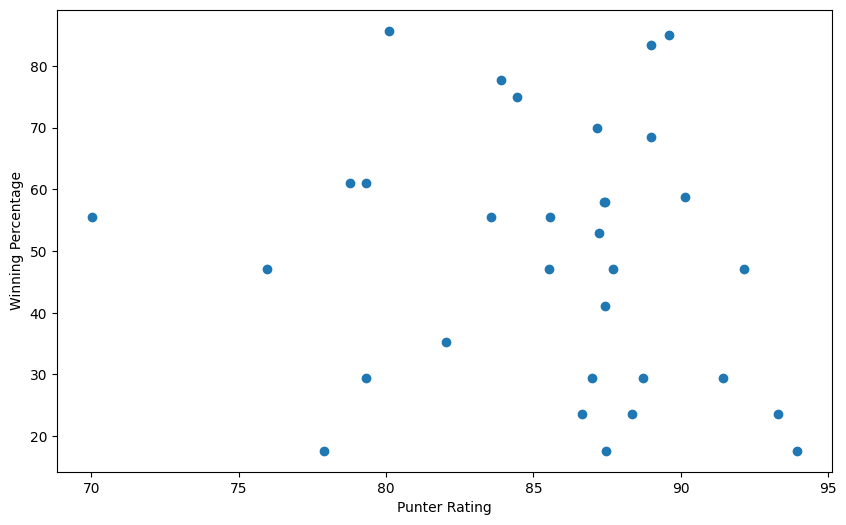

In [14]:
# Graph Punter Rating vs Winning Percentage
plt.figure(figsize=(10, 6))
plt.scatter(team_stats_df['Punter_Rating'], team_stats_df['Win_Percentage'])
plt.xlabel('Punter Rating')
plt.ylabel('Winning Percentage')

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/dist-packages/matplotlib/pyplot.py'>

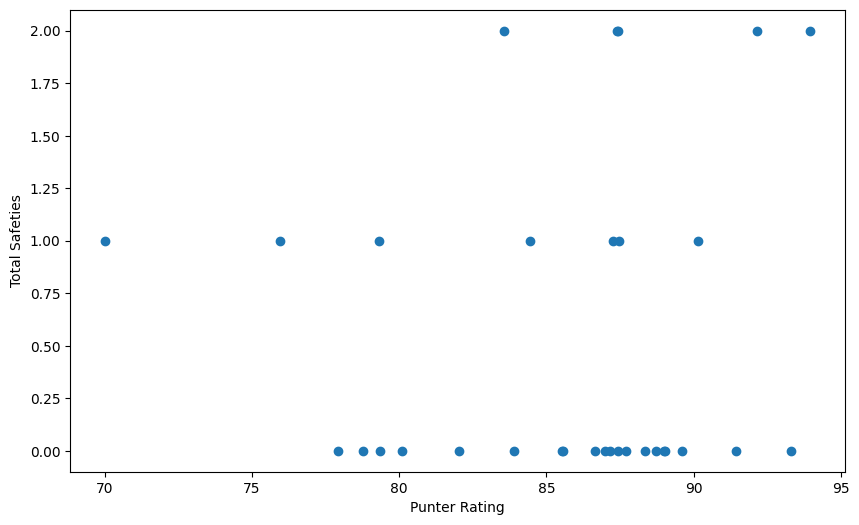

In [15]:
# graph punter rating vs total_safeties
plt.figure(figsize=(10, 6))
plt.scatter(team_stats_df['Punter_Rating'], team_stats_df['Total Safeties'])
plt.xlabel('Punter Rating')
plt.ylabel('Total Safeties')
plt

# **How does Punter Rating compares to common punter metrics?**

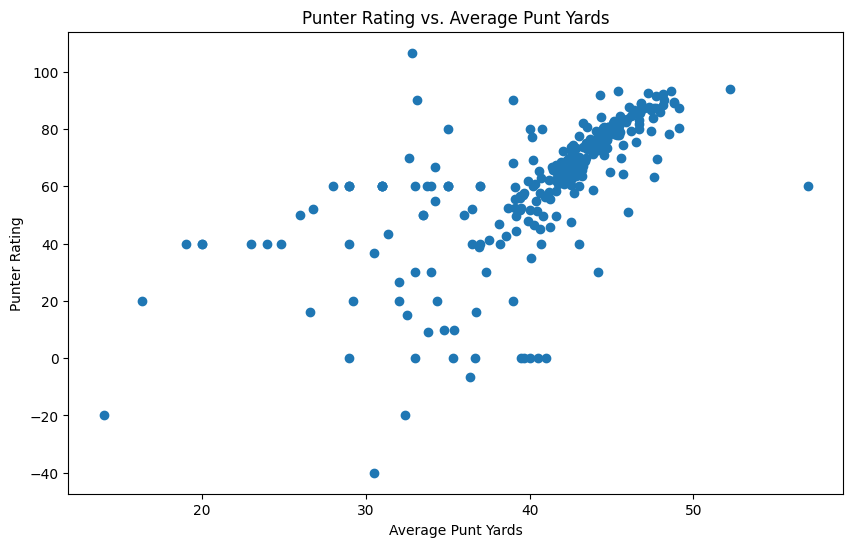

In [16]:
# Ensure 'punt_in_endzone', 'punt_finish', and 'punt_inside_five' columns are present in punt_pbp for the 2024 data.
# These columns were calculated on the all-season punt_pbp earlier, but the punt_pbp DataFrame was reloaded for the 2024 season in a subsequent cell.
if 'punt_in_endzone' not in punt_pbp.columns:
    punt_pbp['punt_in_endzone'] = np.where(punt_pbp['kick_distance'] == punt_pbp['yardline_100'], 1, 0)
if 'punt_finish' not in punt_pbp.columns:
    punt_pbp['punt_finish'] = punt_pbp['yardline_100'] - punt_pbp['kick_distance'] + 20 * punt_pbp['punt_in_endzone'] - punt_pbp['return_yards']
if 'punt_inside_five' not in punt_pbp.columns:
    punt_pbp['punt_inside_five'] = np.where(punt_pbp['punt_finish'] <= 5, 1, 0)

# for each punter, retrieve the punter data
for punter in ppp_punter_df['player_name']:
    punter_data = punt_pbp[punt_pbp['punter_player_name'] == punter]
    if len(punter_data) > 0:
      average_punt_yards = punter_data['kick_distance'].mean()
      punts_inside_5 = punter_data[punter_data['punt_inside_five'] == 1]
      punts_inside_5_pct = len(punts_inside_5) / len(punter_data)
      ppp_punter_df.loc[ppp_punter_df['player_name'] == punter, 'average_punt_yards'] = average_punt_yards
      ppp_punter_df.loc[ppp_punter_df['player_name'] == punter, 'punts_inside_five_pct'] = punts_inside_5_pct

# graph each punter with average_punt_yards on x axis and punter_rating on y axis
plt.figure(figsize=(10, 6))
plt.scatter(ppp_punter_df['average_punt_yards'], ppp_punter_df['punter_rating'])
plt.xlabel('Average Punt Yards')
plt.ylabel('Punter Rating')
plt.title('Punter Rating vs. Average Punt Yards')

# add line of best fit
#slope, intercept = np.polyfit(ppp_punter_df['average_punt_yards'], ppp_punter_df['punter_rating'], 1)
#plt.plot(ppp_punter_df['average_punt_yards'], slope * ppp_punter_df['average_punt_yards'] + intercept, color='red')
plt.show()

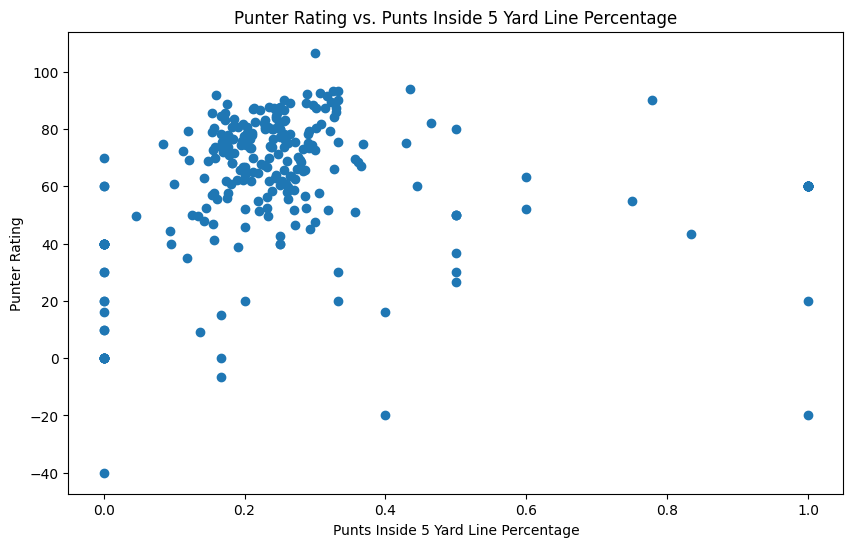

In [17]:
# graph punts_inside_5_pct vs. punter rating
plt.figure(figsize=(10, 6))
plt.scatter(ppp_punter_df['punts_inside_five_pct'], ppp_punter_df['punter_rating'])
plt.xlabel('Punts Inside 5 Yard Line Percentage')
plt.ylabel('Punter Rating')
plt.title('Punter Rating vs. Punts Inside 5 Yard Line Percentage')
plt.show()

In [18]:
# If kick_distance = yardline_100, then 1; otherwise 0
punt_pbp['punt_in_endzone'] = np.where(punt_pbp['kick_distance'] == punt_pbp['yardline_100'], 1, 0)
# Calculate Net Yards
punt_pbp['net_yards'] = punt_pbp['kick_distance'] - punt_pbp['return_yards'] - 20 * punt_pbp['punt_in_endzone']


In [19]:
# find precision punts in punt_pbp where yardline_100 <= 60 and (punt_downed = 1 or punt_out_of_bounds = 1 or punt_in_endzone = 1 or return_yards <= 3
precision_punts = punt_pbp[(punt_pbp['yardline_100'] <= 60) & ((punt_pbp['punt_downed'] == 1) | (punt_pbp['punt_out_of_bounds'] == 1) | (punt_pbp['punt_in_endzone'] == 1) | (punt_pbp['return_yards'] <= 3))]

def epa_pp(yard):
    epa = 0.0621 * (20 - yard)
    return epa

punt_player_list = []

for punter in precision_punts['punter_player_name'].unique():
    punter_data = precision_punts[precision_punts['punter_player_name'] == punter]
    for index, row in punter_data.iterrows():
        yardline = row['yardline_100']
        kick_distance = row['kick_distance']
        net_yards = row['net_yards']
        punt_finish = row['punt_finish']
        punt_inside_twenty = row['punt_inside_twenty']
        punt_inside_five = row['punt_inside_five']
        punt_inside_endzone = row['punt_in_endzone']
        # Calculate EPA per Precison Punt
        epa = epa_pp(punt_finish)
        # add the data to the list
        punt_player_list.append([punter, yardline, kick_distance, net_yards, epa, punt_inside_twenty, punt_inside_five, punt_inside_endzone])

# convert to df
punt_player_data = pd.DataFrame(punt_player_list, columns=['player_name', 'yardline', 'kick_distance', 'net_yards', 'epa', 'punt_inside_twenty', 'punt_inside_five', 'punt_in_endzone'])

punter_summary = punt_player_data.groupby('player_name', as_index=False).agg(
    mean_epa=('epa', 'mean'),
    num_punts=('kick_distance', 'count'),
    punt_inside_twenty_pct=('punt_inside_twenty', 'mean'),
    punt_inside_five_pct=('punt_inside_five', 'mean'),
    touchback_pct=('punt_in_endzone', 'mean')
)

punter_summary['precision_touchback_ratio'] = punter_summary['punt_inside_twenty_pct'] / punter_summary['touchback_pct']

punter_summary = punter_summary.sort_values(by='mean_epa', ascending=False).reset_index(drop=True)
punter_summary = punter_summary.loc[punter_summary['num_punts'] > 25]
punter_summary

,player_name,mean_epa,num_punts,punt_inside_twenty_pct,punt_inside_five_pct,touchback_pct,precision_touchback_ratio
34,C. Hanson,0.878600,27,0.592593,0.666667,0.370370,1.600000
37,R.Stonehouse,0.840251,49,0.653061,0.387755,0.326531,2.000000
45,J.Kapinos,0.763698,47,0.574468,0.446809,0.340426,1.687500
46,M. Berger,0.763465,34,0.647059,0.441176,0.294118,2.200000
47,S.Lechler,0.761343,427,0.651054,0.414520,0.285714,2.278689
...,...,...,...,...,...,...,...
207,S.Rocca,0.477692,169,0.763314,0.177515,0.106509,7.166667
208,T.Long,0.470653,38,0.657895,0.210526,0.184211,3.571429
209,B.LaFleur,0.466752,31,0.645161,0.258065,0.096774,6.666667
216,K.Walter,0.398310,157,0.656051,0.203822,0.108280,6.058824


# **Create Precision Boost Statistic to find best purely Precision Punters**

In [20]:
# If kick_distance = yardline_100, then 1; otherwise 0
punt_pbp['punt_in_endzone'] = np.where(punt_pbp['kick_distance'] == punt_pbp['yardline_100'], 1, 0)
# Calculate Net Yards
punt_pbp['net_yards'] = punt_pbp['kick_distance'] - punt_pbp['return_yards'] - 20 * punt_pbp['punt_in_endzone']

punt_pbp['punt_land'] = punt_pbp['yardline_100'] - punt_pbp['kick_distance'] + 20 * punt_pbp['punt_in_endzone']

def precision_boost(yard):
    # Use ** for exponentiation
    points = 1 + 5 * np.exp(-0.25 * yard)
    return points

punt_pbp['precision_boost'] = punt_pbp['punt_land'].apply(precision_boost)

punt_player_list = []

# for each player
for player in punt_pbp['punter_player_name'].unique():
    # only include their punts
    player_data = punt_pbp[(punt_pbp['punter_player_name'] == player) & (punt_pbp['yardline_100'] < 61) ]
    # for each punt in player_data
    for index, row in player_data.iterrows():
        # get the yardline and kick distance
        yardline = row['yardline_100']
        kick_distance = row['kick_distance']
        net_yards = row['net_yards']
        punt_land = row['punt_land']
        precision_boost_value = row['precision_boost'] # Renamed variable to avoid conflict
        # find the expected distance based on field position
        # add the data to the list
        # Extract the scalar player name from the Series
        player_name_scalar = player_data['punter_player_name'].iloc[0]
        punt_player_list.append([player_name_scalar, yardline, kick_distance, net_yards, punt_land, precision_boost_value])

# convert to df
punt_player_data = pd.DataFrame(punt_player_list, columns=['player_name', 'yardline', 'kick_distance', 'net_yards', 'punt_land', 'precision_boost'])

punter_summary = punt_player_data.groupby('player_name', as_index=False).agg(
    precision_boost=('precision_boost', 'mean'),
    num_punts=('kick_distance', 'count') # Added num_punts back
)
# sort by precision boost
punter_summary = punter_summary.sort_values(by='precision_boost', ascending=False).reset_index(drop=True)
punter_summary = punter_summary.loc[punter_summary['num_punts'] > 20]
punter_summary

,player_name,precision_boost,num_punts
8,W.Brice,3.062474,22
21,C. Hanson,1.871667,33
24,B.Gillikin,1.824903,82
26,M.Wishnowsky,1.808204,132
29,B.Hartmann,1.748214,21
...,...,...,...
210,L.Aguiar,1.248440,50
212,B.Bartholomew,1.239869,26
220,R. Williams,1.185187,26
223,E. Johnson,1.166002,22


# **Exploration: What yardage and precision punts can be expected based on punting field position?**

In [21]:
expected_punting = []

# for each starting yard line, find average kick_distance, punt_inside_twenty, punt_in_endzone
for yard_line in punt_pbp['yardline_100'].unique():
    avg_kick = punt_pbp[punt_pbp['yardline_100'] == yard_line]['kick_distance'].mean()
    inside_twenty_pct = punt_pbp[punt_pbp['yardline_100'] == yard_line]['punt_inside_twenty'].mean()
    in_endzone_pct = punt_pbp[punt_pbp['yardline_100'] == yard_line]['punt_in_endzone'].mean()
    num_punts = punt_pbp[punt_pbp['yardline_100'] == yard_line].shape[0]
    net_yard_avg = punt_pbp[punt_pbp['yardline_100'] == yard_line]['net_yards'].mean()

    expected_punting.append([yard_line, num_punts, avg_kick, inside_twenty_pct, in_endzone_pct, net_yard_avg])

expected_punting_df = pd.DataFrame(expected_punting, columns=['yardline', 'number_of_punts', 'avg_kick_distance', 'punt_inside_twenty_pct', 'punt_in_endzone_pct', 'net_yard_average'])
expected_punting_df.sort_values(by='yardline', inplace=True)
expected_punting_df

,yardline,number_of_punts,avg_kick_distance,punt_inside_twenty_pct,punt_in_endzone_pct,net_yard_average
71,24.0,1,24.000000,0.000000,1.000000,4.000000
70,27.0,2,25.000000,0.500000,0.500000,15.000000
73,28.0,3,20.333333,0.333333,0.333333,8.000000
65,29.0,7,23.285714,0.857143,0.142857,19.857143
69,30.0,14,24.928571,0.571429,0.357143,16.571429
...,...,...,...,...,...,...
66,95.0,280,47.639286,0.000000,0.000000,40.367857
45,96.0,178,47.842697,0.000000,0.000000,39.561798
62,97.0,148,48.716216,0.000000,0.000000,40.668919
60,98.0,140,47.264286,0.000000,0.000000,38.642857


a=0.0782, b=28.0676, c=41.6601


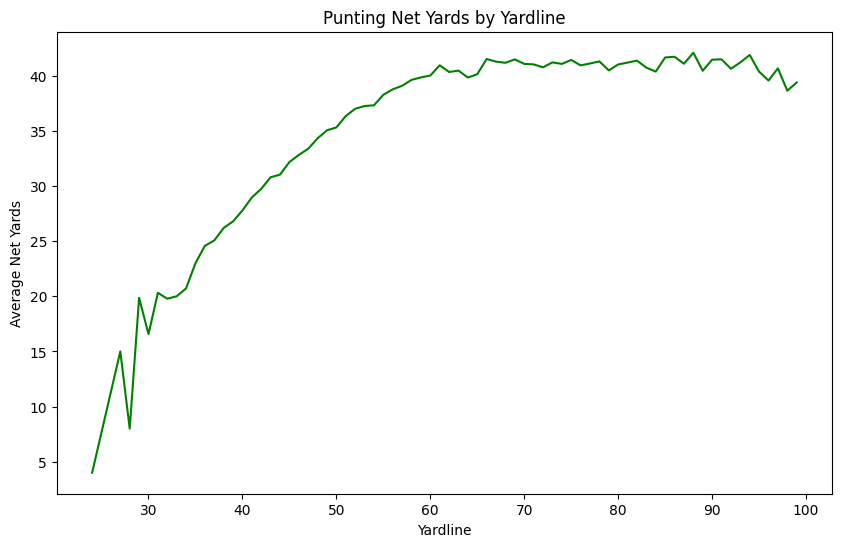

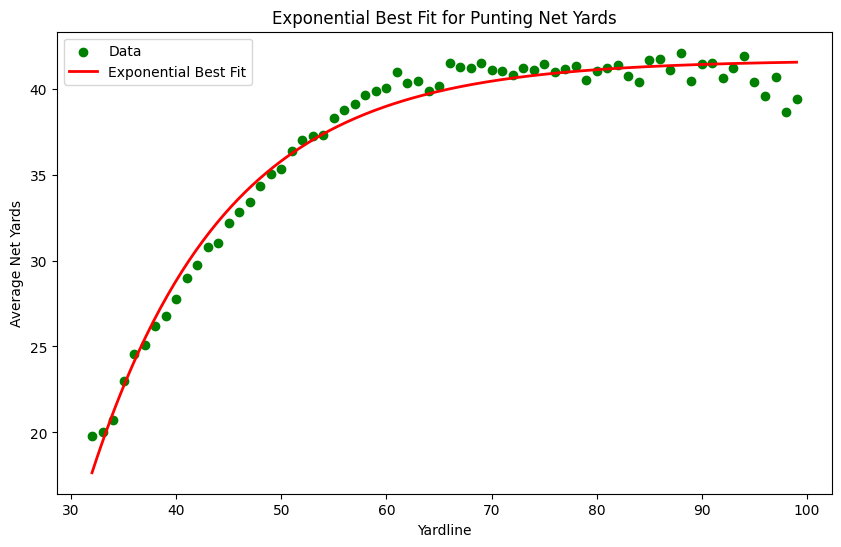

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Plot the original data
plt.figure(figsize=(10, 6))
plt.plot(expected_punting_df['yardline'], expected_punting_df['net_yard_average'],
         label='Average Net Yards', color='green')
plt.xlabel('Yardline')
plt.ylabel('Average Net Yards')
plt.title('Punting Net Yards by Yardline')

# Exponential decay function (approaches asymptote c)
def exponential_function_2(x, a, b, c):
    return c - b * np.exp(-a * (x - 30))

# Filter data for yardline > 31
mask = expected_punting_df['yardline'] > 31
x_data = expected_punting_df.loc[mask, 'yardline'].reset_index(drop=True)
y_data = expected_punting_df.loc[mask, 'net_yard_average'].reset_index(drop=True)

# Initial guess: [rate, amplitude, asymptote]
initial_guess = [0.05, 10, 45]

# Fit the model
params, cov = curve_fit(
    exponential_function_2,
    x_data,
    y_data,
    p0=initial_guess,
    maxfev=10000
)

a_fit_2, b_fit_2, c_fit_2 = params
print(f"a={a_fit_2:.4f}, b={b_fit_2:.4f}, c={c_fit_2:.4f}")

# Generate smooth curve for plotting
x_fit = np.linspace(x_data.min(), x_data.max(), 300)
y_fit = exponential_function_2(x_fit, *params)

# Plot fitted curve
plt.figure(figsize=(10, 6))
plt.scatter(x_data, y_data, color='green', label='Data')
plt.plot(x_fit, y_fit, color='red', linewidth=2, label='Exponential Best Fit')
plt.xlabel('Yardline')
plt.ylabel('Average Net Yards')
plt.title('Exponential Best Fit for Punting Net Yards')
plt.legend()
plt.show()

a=0.0625, b=27.3022, c=48.6781


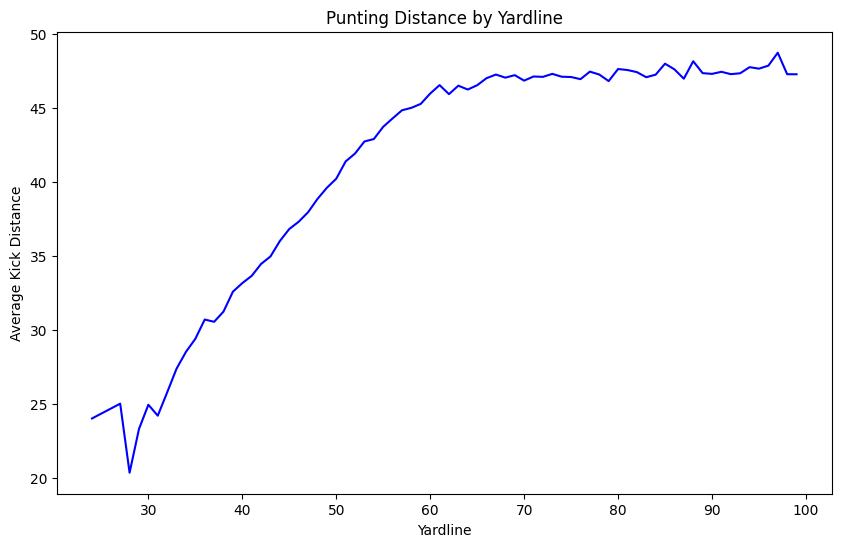

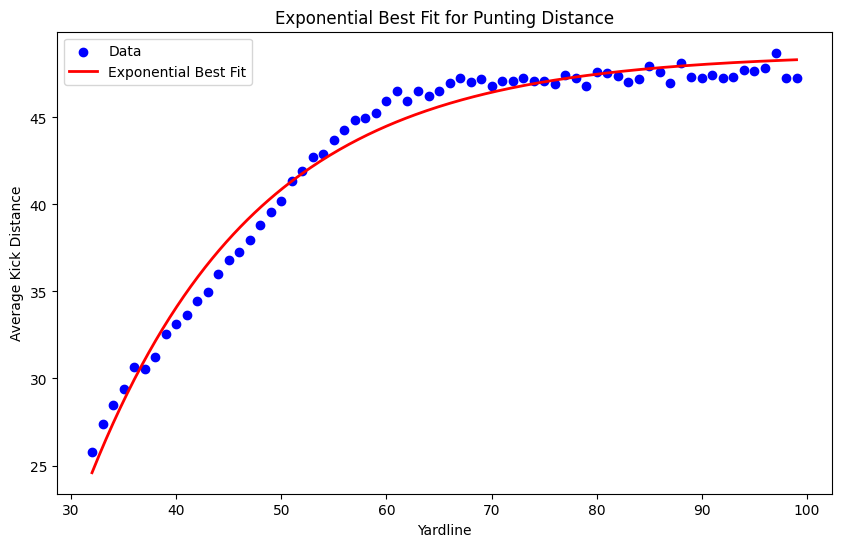

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Plot the original data
plt.figure(figsize=(10, 6))
plt.plot(expected_punting_df['yardline'], expected_punting_df['avg_kick_distance'],
         label='Average Kick Distance', color='blue')
plt.xlabel('Yardline')
plt.ylabel('Average Kick Distance')
plt.title('Punting Distance by Yardline')

# Exponential decay function (approaches asymptote c)
def exponential_function(x, a, b, c):
    return c - b * np.exp(-a * (x - 30))

# Filter data for yardline > 31
mask = expected_punting_df['yardline'] > 31
x_data = expected_punting_df.loc[mask, 'yardline'].reset_index(drop=True)
y_data = expected_punting_df.loc[mask, 'avg_kick_distance'].reset_index(drop=True)

# Initial guess
initial_guess = [0.05, 10, 48]  # rate, amplitude, asymptote

# Fit the model
params, cov = curve_fit(
    exponential_function,
    x_data,
    y_data,
    p0=initial_guess,
    maxfev=10000
)

a_fit, b_fit, c_fit = params
print(f"a={a_fit:.4f}, b={b_fit:.4f}, c={c_fit:.4f}")

# Generate smooth curve for plotting
x_fit = np.linspace(x_data.min(), x_data.max(), 300)
y_fit = exponential_function(x_fit, *params)

# Plot fitted curve
plt.figure(figsize=(10, 6))
plt.scatter(x_data, y_data, color='blue', label='Data')
plt.plot(x_fit, y_fit, color='red', linewidth=2, label='Exponential Best Fit')
plt.xlabel('Yardline')
plt.ylabel('Average Kick Distance')
plt.title('Exponential Best Fit for Punting Distance')
plt.legend()
plt.show()


### Find Best Punters by Overpunting the Expectations

In [24]:
punt_player_data = []

# for each player
for player in punt_pbp['punter_player_name'].unique():
    # only include their punts
    player_data = punt_pbp[punt_pbp['punter_player_name'] == player]
    # for each punt in player_data
    for index, row in player_data.iterrows():
        # get the yardline and kick distance
        yardline = row['yardline_100']
        kick_distance = row['kick_distance']
        net_yards = row['net_yards']
        # find the expected distance based on field position
        expected_distance = exponential_function(yardline, a_fit, b_fit, c_fit)
        expected_net_distance = exponential_function_2(yardline, a_fit_2, b_fit_2, c_fit_2)
        # calculate the distance overexpected
        distance_overexpected = kick_distance - expected_distance
        netyards_overexpected = net_yards - expected_net_distance
        # add the data to the list
        # Extract the scalar player name from the Series
        player_name_scalar = player_data['punter_player_name'].iloc[0]
        punt_player_data.append([player_name_scalar, yardline, kick_distance, expected_distance, distance_overexpected, netyards_overexpected])

# convert to dataframe
punt_player_df = pd.DataFrame(punt_player_data, columns=['player_name', 'yardline', 'kick_distance', 'expected_distance', 'distance_overexpected', 'netyards_overexpected'])

# group by player, finding the mean of distance_overexpected, and total number of punts
punter_summary = (
    punt_player_df
    .groupby('player_name', as_index=False)
    .agg(
        mean_distance_overexpected=('distance_overexpected', 'mean'),
        num_punts=('kick_distance', 'count'),
        avg_kick_distance=('kick_distance', 'mean'),
        avg_net_yards=('netyards_overexpected', 'mean')
    )
)

# Filter to only include punters with more than 10 punts
punter_summary = punter_summary.loc[punter_summary['num_punts'] > 100]

# Sort by distance_overexpected (descending)
punter_summary = punter_summary.sort_values(by='mean_distance_overexpected', ascending=False).reset_index(drop=True)

punter_summary

#exponential_function(x, a_fit, b_fit, c_fit)

,player_name,mean_distance_overexpected,num_punts,avg_kick_distance,avg_net_yards
0,R.Stonehouse,7.187943,216,52.231481,3.530085
1,A.Cole,4.391365,374,48.644385,4.146117
2,J.Fox,4.104663,278,48.780576,4.314211
3,J.Camarda,3.948814,169,49.124260,2.002091
4,M.Dickson,3.673713,504,48.176587,4.288800
...,...,...,...,...,...
117,D.Stryzinski,-4.073085,235,39.425532,-1.797707
118,C.Mohr,-4.294001,459,39.651416,-2.791618
119,T.Barnhardt,-4.472620,161,39.888199,-3.820689
120,K.Walter,-4.872982,364,38.692308,-2.699312


### Expected punts inside the 20 by Punt Field Position

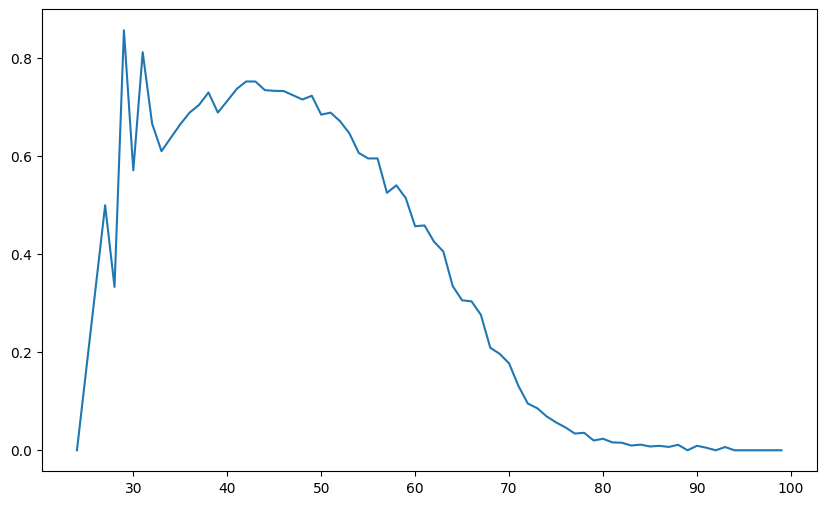

In [25]:
# plot expected_punting_df
plt.figure(figsize=(10, 6))
plt.plot(expected_punting_df['yardline'], expected_punting_df['punt_inside_twenty_pct'], label='Average Kick Distance')